In [303]:
%matplotlib inline

import numpy as np
from scipy.stats import beta, skewnorm, uniform, expon, lognorm, weibull_min, chi2, t, gumbel_r, wasserstein_distance, moment
from scipy.special import gamma
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
from scipy.stats import ks_2samp

### Distributions of the independent components

In [347]:
rvs = [beta(2,3), beta(2,6), skewnorm(a=6), gumbel_r, lognorm(s=1), weibull_min(c=2), chi2(df=6)]

In [348]:
def sample_normed(n, rv):
    return (rv.rvs(size=n) - rv.mean()) / rv.std()

In [349]:
n = 5000
eps = np.zeros((n,len(rvs)))
for i, rv in enumerate(rvs):
    eps[:,i] = sample_normed(n,rv)

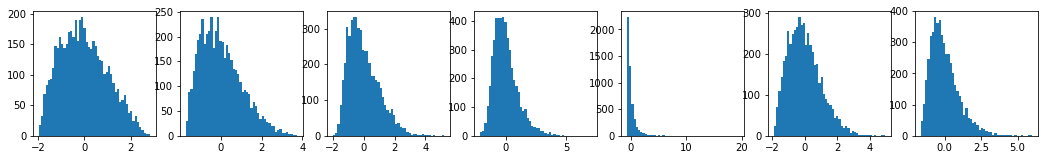

In [350]:
fig, ax = plt.subplots(1, 7, figsize=(18,2.3))

for j in range(7):
        ax[j].hist(eps[:,j], bins=50)

plt.show()

### Create synthetic observations

In [351]:
joint_latents = [0,1,2,3]
env1_specific = [4]
env2_specific = [5]
env3_specific = [6]
d1 = 13
d2 = 14
d3 = 15
n1 = 25000
n2 = 25000
n3 = 25000

env1_latents = joint_latents + env1_specific
env2_latents = joint_latents + env2_specific
env3_latents = joint_latents + env3_specific

In [352]:
def matrix_from_normal(shape, mu=0, sigma=1):
    A = np.random.normal(loc=mu, scale=sigma, size=shape)
    return A

In [353]:
# Sample entries of G1
#np.random.seed(101)
G1 = matrix_from_normal(shape=(d1,len(env1_latents)))
G1.round(2)

array([[ 0.66,  0.67, -1.32,  0.08,  1.29],
       [-0.57, -0.41, -0.9 ,  0.77, -1.01],
       [ 0.13, -1.39,  0.01, -1.47, -0.69],
       [-0.44, -0.91, -0.75,  0.67,  0.59],
       [-0.78,  0.77, -0.37,  0.99,  1.45],
       [ 0.02,  0.16, -0.35, -1.71,  1.11],
       [-1.8 , -1.26, -0.44,  0.32,  1.53],
       [ 0.8 , -0.67, -1.66, -1.12, -0.06],
       [-0.93, -0.2 , -1.02,  1.17, -0.85],
       [ 0.64, -0.86, -0.23,  0.32,  0.32],
       [-0.  ,  0.64, -1.55,  0.03,  0.49],
       [ 0.81,  0.04,  0.64, -0.62, -0.77],
       [-0.53,  0.02,  0.58, -1.71,  0.75]])

In [354]:
# G2 and G3
#np.random.seed(102)
G2 = matrix_from_normal(shape=(d2,len(env2_latents)))

#np.random.seed(103)
G3 = matrix_from_normal(shape=(d3,len(env3_latents)))

In [355]:
def sample(n, mixing, rvs):
    nr_comps = len(rvs)
    eps = np.zeros((n,nr_comps))
    for i, rv in enumerate(rvs):
        eps[:,i] = sample_normed(n,rv)
    X = np.matmul(mixing, np.transpose(eps))
    return(X)

In [356]:
# Create synthetic data (uncoupled!!)
X1 = sample(n1, G1, [rvs[i] for i in env1_latents])
X2 = sample(n2, G2, [rvs[i] for i in env2_latents])
X3 = sample(n3, G3, [rvs[i] for i in env3_latents])

### Apply linear ICA to recover the (empirical) distribution of the sources

In [357]:
def rescale_columns(X):
    for i in range(X.shape[1]):
        X[:,i] = (X[:,i] - X[:,i].mean()) / X[:,i].std()
    return X

# X1 has shape p x n
def get_sources(X, seed=101):
    cov = np.cov(X)
    rk = np.linalg.matrix_rank(cov)
    print("Rank:", rk)
    
    ICA = FastICA(n_components=rk, random_state=seed, whiten='unit-variance', max_iter=1000) 
    ICA.fit(np.transpose(X))
    print("Iterations:", ICA.n_iter_)
    eps = ICA.transform(np.transpose(X))
    scaling = eps.std(axis=0)
    
    eps = rescale_columns(eps)
    mixing = np.matmul(ICA.mixing_, np.diag(scaling))    
    
    return eps, mixing

In [358]:
eps1, mixing1 = get_sources(X1)

Rank: 5
Iterations: 7


In [359]:
mixing1

array([[-0.21657147,  1.46498903, -0.64166545, -1.29185803,  0.13025176],
       [ 0.69238053,  0.72413998,  0.60718864,  1.0156274 ,  0.73321181],
       [ 1.25140173, -0.41253406, -0.14023417,  0.69785435, -1.54512602],
       [ 1.12359067,  0.43192535,  0.46976615, -0.58591721,  0.61148312],
       [-0.57725679,  0.55863027,  0.78622279, -1.45612006,  1.02352864],
       [-0.12795693,  0.4036374 , -0.04309246, -1.1243366 , -1.69683311],
       [ 1.32164943,  0.01618202,  1.82568053, -1.53497623,  0.22374349],
       [ 1.0966562 ,  1.40558975, -0.77540635,  0.07015765, -1.14601683],
       [ 0.54281019,  0.89016945,  0.96630707,  0.8594551 ,  1.14442136],
       [ 0.91986353, -0.03401019, -0.62342832, -0.3147426 ,  0.28415483],
       [-0.13480145,  1.66823198,  0.02435279, -0.49088332,  0.07161292],
       [-0.25112417, -0.5858771 , -0.83207943,  0.77575552, -0.60265396],
       [-0.29457638, -0.54118522,  0.48727726, -0.76690977, -1.71383655]])

In [360]:
eps2, mixing2 = get_sources(X2, seed=102)

Rank: 5
Iterations: 5


In [361]:
eps3, mixing3 = get_sources(X3, seed=103)

Rank: 5
Iterations: 5


In [362]:
# Collect results
indep_comps = [eps1, eps2, eps3]
mixings = [mixing1, mixing2, mixing3]

### Plot recovered distributions

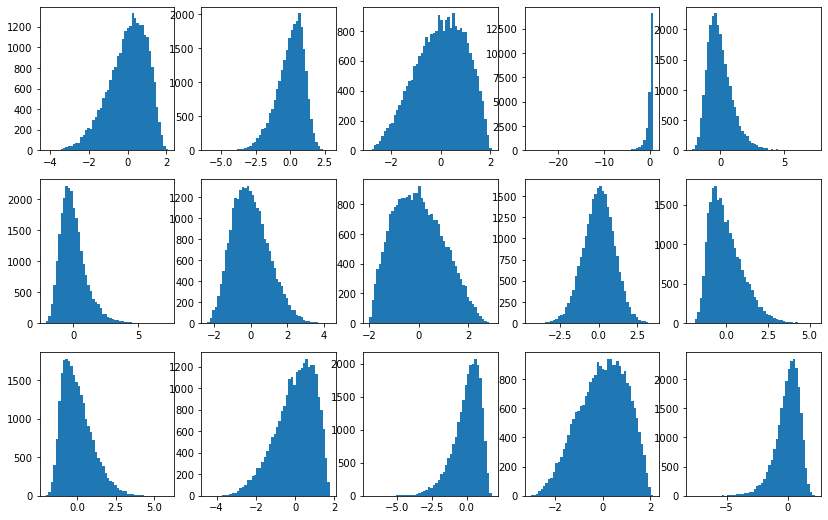

In [363]:
fig, ax = plt.subplots(3, 5, figsize=(14, 9))

for i in range(3):
    for j in range(5):
        ax[i,j].hist(indep_comps[i][:,j], bins=50)

plt.show()

### Matching

In [364]:
def third_moments_distance(X,Y):
    M_X = moment(X, moment=3) # central moment
    M_Y = moment(Y, moment=3)
    dist = abs(M_X - M_Y)
    return dist

In [365]:
# 1-Wasserstein metric between empirical distributions

def wasserstein_dist(X1,X2):
    p1 = X1.shape[1]
    p2 = X2.shape[1]
    D = np.zeros((p1,p2))
    for i in range(p1):
        for j in range(p2):
            D[i,j] = wasserstein_distance(X1[:,i],X2[:,j]) 
    return D


def wasserstein_dist_signed(X1,X2):
    p1 = X1.shape[1]
    p2 = X2.shape[1]
    D_large = np.zeros((p1,2*p2))
    X2_large = np.concatenate((X2,-X2),axis=1)
    for i in range(p1):
        for j in range(2*p2):
            D_large[i,j] = wasserstein_distance(X1[:,i],X2_large[:,j]) 
    D = np.zeros((p1,p2))
    for i in range(p2):
        D[:,i] = D_large[:,[i,i+p2]].min(axis=1)
    return D

In [366]:
def signed_pvalues_matrix(X1,X2):
    p1 = X1.shape[1]
    p2 = X2.shape[1]
    pvals_large = np.zeros((p1,2*p2))
    X2_large = np.concatenate((X2,-X2),axis=1)
    for i in range(p1):
        for j in range(2*p2):
            pvals_large[i,j] = ks_2samp(X1[:,i],X2_large[:,j]).pvalue
    pvals = np.zeros((p1,p2))
    for i in range(p2):
        pvals[:,i] = pvals_large[:,[i,i+p2]].max(axis=1)
    return pvals

In [367]:
def minimum_matching(D, A=10):
    p1, p2 = D.shape
    threshold = A * D.min()
    matching = {}
    for i in range(p1):
        row_argmin = D[i,:].argmin()
        row_min = D[i,:].min()
        if (D[:,row_argmin].argmin() == i) and (row_min < threshold):
            matching[i] = row_argmin
    return matching

In [368]:
def maximum_matching(pvals, level=0.05):
    p1, p2 = pvals.shape
    matching = {}
    for i in range(p1):
        row_argmax = pvals[i,:].argmax()
        row_max = pvals[i,:].max()
        if (pvals[:,row_argmax].argmax() == i) and (row_max >= level):
            matching[i] = row_argmax
    return matching

In [369]:
adj_alpha=0.05/75

In [370]:
P12 = signed_pvalues_matrix(eps1,eps2).round(3)
P12.round(3)

array([[0.   , 0.001, 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.813, 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.424, 0.   , 0.   , 0.   , 0.   ]])

In [377]:
maximum_matching(P12, level=adj_alpha)

{0: 1, 2: 2, 4: 0}

In [373]:
P13 = signed_pvalues_matrix(eps1,eps3).round(3)
P13.round(3)

array([[0.   , 0.026, 0.   , 0.   , 0.   ],
       [0.005, 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.968, 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.826]])

In [374]:
maximum_matching(P13, level=adj_alpha)

{0: 1, 1: 0, 2: 3, 4: 4}

In [375]:
P23 = signed_pvalues_matrix(eps1,eps3).round(3)
P23.round(3)

array([[0.   , 0.026, 0.   , 0.   , 0.   ],
       [0.005, 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.968, 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.826]])

In [376]:
maximum_matching(P23, level=adj_alpha)

{0: 1, 1: 0, 2: 3, 4: 4}

In [332]:
# Definition of a joint factor:
# A collection of distributions of size |E| such that 
# - all distibutions within that joint factor match

In [333]:
def is_consistent(f, matchings):
    for i in range(len(f)):
        for j in range(i+1, len(f)):
            if f[i] not in list(matchings[str(i)+str(j)].keys()):
                return False
            if matchings[str(i)+str(j)][f[i]] != f[j]:
                return False
    return True



def get_joint_factors(indep_comps):
    
    nr_env = len(indep_comps)
    
    matchings = {}
    for i in range(nr_env):
        for j in range(i+1, nr_env):
            D = wasserstein_dist_signed(indep_comps[i],indep_comps[j])
            matchings[str(i)+str(j)] = minimum_matching(D)
    
    # Define potential factors
    pot_factors = [[i] for i in list(matchings['01'].keys())] 
    for f in pot_factors:
        for i in range(1,nr_env):
            if f[0] not in list(matchings['0'+str(i)].keys()):
                continue
            else:
                f.append(matchings['0'+str(i)][f[0]])
    pot_factors = [f for f in pot_factors if len(f)==nr_env]
    
    # Only keep consistent factors
    factors = [f for f in pot_factors if is_consistent(f, matchings)]
    
    return(factors)

In [334]:
joint_factors = get_joint_factors(indep_comps)
joint_factors

# Interpretation:
# We match the following recovered components:
# component 0 of domain 1 WITH component 0 of domain 2 WITH component 2 of domain 3

[[0, 0, 4], [1, 4, 2], [4, 2, 1]]

### Recover joint mixing matrix

In [335]:
def matching_sign(distr1, distr2):
        normal_dist = wasserstein_distance(distr1,distr2) 
        flipped_dist = wasserstein_distance(distr1,-distr2)
        if normal_dist >= flipped_dist:
            return 1
        else:
            return -1 

In [336]:
def add_signs_to_factor(f, indep_comps):
    
    signs = [1]
    
    for i in range(1,len(f)):
        signs.append(matching_sign(indep_comps[0][:,f[0]], indep_comps[i][:,f[i]]))
         
    return signs

In [337]:
joint_factor_signs = [add_signs_to_factor(f, indep_comps) for f in joint_factors]
joint_factor_signs

[[1, 1, -1], [1, -1, -1], [1, 1, 1]]

In [338]:
def joint_mixing_matrix(mixings, joint_factors, joint_factor_signs):
    
    nr_env = len(mixings)
    nr_joint = len(joint_factors)
    total_nr_obs = sum([M.shape[0] for M in mixings])
    total_nr_lat = sum([M.shape[1]-nr_joint for M in mixings]) + nr_joint
    M_large = np.zeros((total_nr_obs, total_nr_lat))
    
    # Joint columns
    for i,f in enumerate(joint_factors):
        current_row = 0
        for env in range(nr_env):
            col = joint_factor_signs[i][env] * mixings[env][:,f[env]]
            M_large[np.ix_(np.arange(current_row,(current_row+len(col))),np.array([i]))] \
            = col.reshape((len(col),1))
            current_row = current_row + len(col)
    
    # Domain-specific columns
    current_col = len(joint_factors)
    current_row = 0
    for env in range(nr_env):
        M = mixings[env]
        nrows, ncols = M.shape
        joint_cols = [f[env] for f in joint_factors]
        domain_spec_cols = set(np.arange(ncols)) - set(joint_cols)
        for i, col in enumerate(domain_spec_cols):
            M_large[np.ix_(np.arange(current_row,(current_row+nrows)),np.array([current_col+i]))] \
            = M[:,col].reshape((nrows,1))
        current_col = current_col + len(domain_spec_cols)
        current_row = current_row + nrows
    return(M_large)

In [339]:
B = joint_mixing_matrix(mixings, joint_factors, joint_factor_signs).round(2)
B

array([[ 0.08, -0.34,  0.73,  1.4 ,  0.57,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.25,  0.64, -0.18,  1.75,  0.67,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 1.42,  1.19,  0.08,  0.84,  0.57,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.39,  0.9 ,  0.48, -1.92,  0.  ,  0.  ,  0.  ,  0.  ],
       [-0.32, -1.43, -1.93,  0.24, -0.65,  0.  ,  0.  ,  0.  ,  0.  ],
       [-0.71, -2.05,  0.11,  0.83,  0.17,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.2 , -0.09,  1.12,  0.86, -0.36,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.7 ,  0.19, -1.33, -0.76,  0.63,  0.  ,  0.  ,  0.  ,  0.  ],
       [-0.98, -0.12, -0.45, -1.43, -0.16,  0.  ,  0.  ,  0.  ,  0.  ],
       [-2.83, -0.39,  1.55, -0.2 , -0.85,  0.  ,  0.  ,  0.  ,  0.  ],
       [-0.63,  0.04,  0.76, -0.89, -0.54,  0.  ,  0.  ,  0.  ,  0.  ],
       [-0.63, -1.08, -0.1 , -0.04,  1.26,  0.  ,  0.  ,  0.  ,  0.  ],
       [-1.04, -0.1 , -0.26,  0.18,  0.77,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 1.31,  0.51, -1.08,  0.  ,  0.  ,  0.37,  0.4 ,  0.  , 

For comparison:

In [340]:
G1.round(2)

array([[ 0.34, -0.75, -0.53, -0.07,  1.42],
       [-0.62,  0.18, -0.68, -0.28,  1.76],
       [-1.14, -0.1 , -0.57, -1.46,  0.85],
       [-0.45, -0.82,  1.92,  0.05,  0.47],
       [ 1.45,  1.93,  0.63,  0.33,  0.21],
       [ 2.04, -0.13, -0.13,  0.76,  0.84],
       [ 0.07, -1.11,  0.39, -0.16,  0.87],
       [-0.14,  1.29, -0.66, -0.74, -0.77],
       [ 0.11,  0.47,  0.12,  0.98, -1.44],
       [ 0.28, -1.46,  0.84,  2.9 , -0.19],
       [-0.08, -0.73,  0.54,  0.66, -0.88],
       [ 1.1 ,  0.05, -1.24,  0.63, -0.02],
       [ 0.11,  0.27, -0.79,  1.02,  0.19]])

In [341]:
G2.round(2)

array([[ 0.53, -1.03, -0.49,  1.32, -0.31],
       [ 1.36, -0.84,  0.32, -0.09, -0.09],
       [ 1.01, -1.35,  1.74, -1.82, -0.42],
       [-0.42,  0.41,  0.71, -0.86, -0.45],
       [ 1.43, -0.67, -0.48, -0.04,  1.  ],
       [-0.04,  0.16, -1.  ,  0.34, -1.13],
       [ 0.24,  1.09,  1.13, -1.28, -1.88],
       [ 0.05, -0.96,  0.93,  1.58, -0.02],
       [ 1.11,  0.43, -0.82,  0.19, -2.01],
       [-1.5 , -1.06, -0.31, -0.04, -0.55],
       [-1.02, -1.32,  0.28,  0.06, -0.75],
       [-0.54, -0.21,  2.72,  1.36, -0.41],
       [ 0.8 , -1.88, -1.54, -0.02,  0.21],
       [-0.72, -1.71,  0.87, -1.22, -0.01]])

In [342]:
G3.round(2)

array([[ 1.3 , -2.41,  1.53, -0.48,  0.  ],
       [ 1.64,  2.33,  2.36,  0.19,  2.8 ],
       [-1.86, -1.22, -0.09,  1.39,  1.  ],
       [ 0.2 ,  1.42,  0.83,  0.65, -0.41],
       [-0.49,  1.33, -0.11,  1.31, -0.03],
       [-1.12,  0.26,  0.73, -0.  ,  1.06],
       [ 0.11, -0.09,  0.05,  0.56, -0.09],
       [ 0.6 , -1.03, -0.97, -0.36, -1.18],
       [-0.14, -0.7 , -2.03,  1.3 , -0.84],
       [ 0.73, -0.59,  1.17,  1.23, -0.43],
       [ 0.49,  1.5 ,  0.29,  0.47,  0.79],
       [-1.64,  0.52,  1.69,  0.71, -0.7 ],
       [-0.9 ,  0.31, -0.57,  0.46, -0.94],
       [-0.74, -1.18, -0.35,  1.53, -1.29],
       [ 1.28, -1.09,  0.39, -0.44, -0.28]])

In [343]:
mixing1.round(2)

array([[ 0.08, -0.34,  1.4 ,  0.57,  0.73],
       [ 0.25,  0.64,  1.75,  0.67, -0.18],
       [ 1.42,  1.19,  0.84,  0.57,  0.08],
       [ 0.  ,  0.39,  0.48, -1.92,  0.9 ],
       [-0.32, -1.43,  0.24, -0.65, -1.93],
       [-0.71, -2.05,  0.83,  0.17,  0.11],
       [ 0.2 , -0.09,  0.86, -0.36,  1.12],
       [ 0.7 ,  0.19, -0.76,  0.63, -1.33],
       [-0.98, -0.12, -1.43, -0.16, -0.45],
       [-2.83, -0.39, -0.2 , -0.85,  1.55],
       [-0.63,  0.04, -0.89, -0.54,  0.76],
       [-0.63, -1.08, -0.04,  1.26, -0.1 ],
       [-1.04, -0.1 ,  0.18,  0.77, -0.26]])

In [344]:
mixing2.round(2)

array([[ 1.31,  0.37, -1.08,  0.4 , -0.51],
       [-0.1 , -0.27, -0.85, -0.11, -1.37],
       [-1.78, -1.77, -1.33, -0.44, -1.08],
       [-0.81, -0.9 ,  0.41,  0.12,  0.39],
       [-0.13,  0.95, -0.63, -0.68, -1.4 ],
       [ 0.39,  0.37,  0.07,  1.46,  0.08],
       [-1.12, -1.93,  1.02,  1.23, -0.29],
       [ 1.59, -0.77, -0.98, -0.54, -0.09],
       [ 0.29, -0.17,  0.3 ,  2.18, -1.08],
       [-0.02, -0.03, -1.1 ,  0.56,  1.5 ],
       [ 0.09, -0.62, -1.36,  0.45,  0.99],
       [ 1.44, -2.58, -0.21, -0.99,  0.42],
       [-0.1 ,  1.52, -1.9 ,  0.45, -0.74],
       [-1.22, -0.84, -1.69, -0.45,  0.68]])

In [345]:
mixing3.round(2)

array([[ 0.07, -2.39, -1.3 , -1.6 ,  0.44],
       [-2.97,  2.32, -1.63, -2.22, -0.16],
       [-0.98, -1.23,  1.87,  0.09, -1.41],
       [ 0.32,  1.48, -0.22, -0.77, -0.66],
       [-0.04,  1.36,  0.48,  0.18, -1.32],
       [-1.09,  0.26,  1.13, -0.71, -0.  ],
       [ 0.08, -0.08, -0.11, -0.04, -0.56],
       [ 1.25, -1.04, -0.6 ,  0.91,  0.36],
       [ 0.88, -0.73,  0.14,  2.02, -1.3 ],
       [ 0.41, -0.52, -0.74, -1.16, -1.27],
       [-0.88,  1.49, -0.49, -0.21, -0.45],
       [ 0.65,  0.64,  1.63, -1.67, -0.76],
       [ 0.94,  0.34,  0.89,  0.56, -0.47],
       [ 1.32, -1.13,  0.73,  0.32, -1.58],
       [ 0.32, -1.09, -1.28, -0.43,  0.43]])

Notes: 
Could sample from "empirical joint distribution" now:
- Have empirical distribution of each independent component (merge the ones for the joint components).
- Sample from the empirical distributions.
- Using the joint mixing matrix, this produces samples of the joint distribution.

Using the joint mixing matrix we can also transport observations in one domain to another.